In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve

/Users/bachirzerroug/Library/Caches/pypoetry/virtualenvs/transformers-implementation-xd7zxmCX-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Multi Head Attention

In [2]:
class OneHeadSelfAttentionQKV(nn.Module):
    def __init__(self, k, low_dim):
        super().__init__()
        # Check if input is divisible by number of heads
        self.k = k    
        self.low_dim = low_dim 
        # 1. Define linear transformations to reduce dimensionnalité of input
        # biais = False because we want only weights
        self.to_reduce_dim = nn.Linear(k, low_dim, bias=False)
        # 2. Define linear transformations to key, queries and values
        # biais = False because we want only weights
        self.to_queries = nn.Linear(low_dim, low_dim, bias=False)
        self.to_keys    = nn.Linear(low_dim, low_dim, bias=False) 
        self.to_values  = nn.Linear(low_dim, low_dim, bias=False)

    def forward(self, Q, K, V, mask):
        # 3. Reduce dimensionnalité of input
        low_dim_Q = self.to_reduce_dim(Q)
        low_dim_K = self.to_reduce_dim(K)
        low_dim_V = self.to_reduce_dim(V)

        
        # 4. Apply the linear transformation associated to every input to obtain the key, query and value
        query = self.to_queries(low_dim_Q) 
        key = self.to_keys(low_dim_K)
        value = self.to_values(low_dim_V)

        # 5. Compute the raw weights w′ij=𝐪iT𝐤j and normalize them
        weights_raw = torch.bmm(query, key.transpose(1, 2))
        
        # 5.a apply mask
        if mask is not None:
            weights_raw = weights_raw.masked_fill_(mask.logical_not(), float("-1e20"))

        weights_raw_normalized = torch.div(weights_raw, torch.sqrt(torch.tensor(self.low_dim)))

        # 6. We apply the Softmax function to the similarity dimension (batch dim x input dim x sim dim)
        weights = nn.Softmax(dim=2)(weights_raw_normalized)

        # 7. Multiply weights of self attention to the values
        return torch.bmm(weights, value)
    

class MultiHeadSelfAttentionQKV(nn.Module):
    # 8.Define a head number that is divisible from the input 
    def __init__(self, k, heads=4):
        super().__init__()
        # Check if input is divisible by number of heads
        assert k % heads == 0

        self.k = k
        self.heads = heads  

        # 9. Instantiate OneHeadSelfAttention multiple times to have MultiHeadSelfAttention
        self.list_heads = []
        for head in range(self.heads):
            self.list_heads.append(OneHeadSelfAttentionQKV(k, k//heads))

        # This will be applied after the multi-head self-attention operation.
        self.unifyheads = nn.Linear(k, k)
    
    def forward(self, Q, K, V, mask=None):
        # 10. Get all heads elements 
        list_to_concat = []
        for one_head in self.list_heads:
            list_to_concat.append((one_head(Q, K, V, mask),))

        # 11. Concatenate all the heads
        multi_heads = sum(list_to_concat, ())        
        concatenated = torch.cat(multi_heads, dim=2)

        # 12. Linear transformation
        return self.unifyheads(concatenated)


In [3]:
X = torch.rand(12, 100, 256)
mask  = torch.tril(torch.ones((100, 100)), diagonal=1).bool()
M = MultiHeadSelfAttentionQKV(256, 4)
M(X, X, X, mask=mask).size()

torch.Size([12, 100, 256])

## Embeddings

In [4]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, dimension):
        super(Embedding, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, dimension)
        
    def forward(self, x):
        return self.word_embedding(x)

In [5]:
class PositionalEmbedding(nn.Module):
    def __init__(self, dimension, max_seq_length=2000):
        super(PositionalEmbedding, self).__init__()

        positional_encoding = torch.zeros(max_seq_length, dimension)    
        for pos in range(max_seq_length):
            for i in range(dimension):
                if i%2 == 0:
                    pe = math.sin(pos / 1000**(2*i/dimension))
                else:
                    pe = math.cos(pos / 1000**(2*i/dimension))
                positional_encoding[pos, i] = pe

        self.register_buffer('positional_encoding', positional_encoding)
        
    def forward(self, x):
        return x + self.positional_encoding[:x.size(1), :]

## Feed Forward

In [6]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, factor=2):
        super(FeedForward, self).__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, factor*embed_dim),
            nn.ReLU(),
            nn.Linear(factor*embed_dim, embed_dim)
        )  
    
    def forward(self, x):
        return self.feed_forward(x)

<img src="../images/encoder.png" alt="drawing" width="200"/>

In [7]:
class TransformerEncodingBloc(nn.Module):
    def __init__(self, embedding_dim, num_heads, factor):
        super(TransformerEncodingBloc, self).__init__()
        # Mutli Head Attention with its notmalization and its dropout
        self.attention = MultiHeadSelfAttentionQKV(embedding_dim, num_heads)
        self.normalization_mha = nn.LayerNorm(embedding_dim)
        self.dropout_mha = nn.Dropout(0.2)

        # Feed Forward with its notmalization and its dropout
        self.feed_forward = FeedForward(embedding_dim, factor)
        self.normalization_ff = nn.LayerNorm(embedding_dim)
        self.dropout_ff = nn.Dropout(0.2)
        

    def forward(self, query, key, value):
        # Multi Head Attention
        mha = self.attention(query, key, value)
        mha_residuals = mha + value
        mha_residuals_norm = self.normalization_mha(mha_residuals)
        mha_residuals_norm_dropout = self.dropout_mha(mha_residuals_norm)

        # Feed Forward
        ff = self.feed_forward(mha_residuals_norm_dropout)
        ff_residuals = ff + mha_residuals_norm_dropout
        ff_residuals_norm = self.normalization_ff(ff_residuals)
        ff_residuals_norm_dropout = self.dropout_ff(ff_residuals_norm)

        return ff_residuals_norm_dropout


In [8]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, factor):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.positional_embedding = PositionalEmbedding(embedding_dim)
        self.transformer_layers = nn.ModuleList([TransformerEncodingBloc(embedding_dim, num_heads, factor) for i in range(num_layers)])

    def forward(self, X):
        encoded = self.embedding(X)
        output = self.positional_embedding(encoded)
        for transformer_layer in self.transformer_layers:
            output = transformer_layer(output, output, output)
        
        return output
        

In [9]:
X = torch.randint(low=0, high=100, size=(10, 100))

encoder = Encoder(vocab_size=5000, 
                  embedding_dim=256, 
                  num_heads=4,
                  #dropout=0.2,
                  num_layers=5,
                  factor=2
                  )

Y = encoder(X)

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
    "In a cold and gray Chicago morning, a poor little baby child is born in the ghetto",
    "I'll be there for you and the rain starts to pour",
    "I like big butts and I cannot lie",
]

encoded_input = tokenizer(batch_sentences, padding=True, return_tensors="pt")


encoded_input.input_ids.size()

torch.Size([6, 21])

In [11]:
encoder = Encoder(vocab_size=tokenizer.vocab_size, 
                  embedding_dim=256, 
                  num_heads=4,
                  num_layers=5,
                  factor=2
                  )

encoder(encoded_input.input_ids)

tensor([[[ 6.7944e-01,  2.8338e-01, -3.7313e-01,  ...,  0.0000e+00,
          -1.0727e+00, -3.1629e-01],
         [-2.3392e+00,  5.0566e-01, -1.3224e-01,  ...,  1.1924e-02,
          -0.0000e+00,  6.5399e-02],
         [ 1.4677e+00, -4.3367e+00, -0.0000e+00,  ..., -8.7870e-01,
          -5.6033e+00, -3.4865e-01],
         ...,
         [-6.3084e-02,  4.8442e-01, -3.2037e-01,  ...,  4.1424e-01,
          -2.0410e-01, -0.0000e+00],
         [ 5.8662e-01,  1.2720e-01, -0.0000e+00,  ...,  2.9111e-01,
           2.3979e-01, -2.2068e-01],
         [-6.1205e-02, -2.1769e-01, -0.0000e+00,  ...,  1.4815e-01,
          -5.1326e-02, -1.4213e-02]],

        [[-0.0000e+00,  3.2570e-01,  0.0000e+00,  ...,  8.2373e-02,
          -4.1571e-02,  2.7427e-01],
         [-1.7784e+00,  1.1714e+00,  7.8142e-01,  ..., -4.0248e-01,
          -2.3180e-01,  8.7191e-03],
         [-3.0134e-01,  6.6591e-02,  1.7326e+00,  ...,  3.5466e-01,
          -0.0000e+00, -7.6266e-01],
         ...,
         [ 3.7141e-01, -0

<img src="../images/decoder.png" alt="drawing" width="200"/>

In [12]:
class TransformerDecodingBloc(nn.Module):
    def __init__(self, embedding_dim, num_heads, factor):
        super(TransformerDecodingBloc, self).__init__()
        # Mutli Head Self Attention with its notmalization and its dropout
        self.self_attention = MultiHeadSelfAttentionQKV(embedding_dim, num_heads)
        self.normalization_mhsa = nn.LayerNorm(embedding_dim)
        self.dropout_mhsa = nn.Dropout(0.2)

        # Mutli Head cross Attention with its notmalization and its dropout
        self.cross_attention = MultiHeadSelfAttentionQKV(embedding_dim, num_heads)
        self.normalization_mhca = nn.LayerNorm(embedding_dim)
        self.dropout_mhca = nn.Dropout(0.2)

        # Feed Forward with its notmalization and its dropout
        self.feed_forward = FeedForward(embedding_dim, factor)
        self.normalization_ff = nn.LayerNorm(embedding_dim)
        self.dropout_ff = nn.Dropout(0.2)
        

    def forward(self, x, encoder, mask):
        # Mutli Head Self Attention
        mhsa = self.self_attention(x, x, x, mask)
        mhsa_residuals = mhsa + x
        mhsa_residuals_norm = self.normalization_mhsa(mhsa_residuals)
        mhsa_residuals_norm_dropout = self.dropout_mhsa(mhsa_residuals_norm)

        # Mutli Head Cross Attention
        query = mhsa_residuals_norm_dropout
        mhca = self.cross_attention(query, encoder, encoder) # Query belongs to self attention and Key and Value from encoder
        mhca_residuals = mhca + query
        mhca_residuals_norm = self.normalization_mhca(mhca_residuals)
        mhca_residuals_norm_dropout = self.dropout_mhca(mhca_residuals_norm)

         # Feed Forward with its notmalization and its dropout
        ff = self.feed_forward(mhca_residuals_norm_dropout)
        ff_residuals = ff + mhca_residuals_norm_dropout
        ff_residuals_norm = self.normalization_ff(ff_residuals)
        ff_residuals_norm_dropout = self.dropout_ff(ff_residuals_norm)

        return ff_residuals_norm_dropout


In [13]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, factor=1):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.positional_embedding = PositionalEmbedding(embedding_dim)
        self.transformer_layers = nn.ModuleList([TransformerDecodingBloc(embedding_dim, num_heads, factor) for i in range(num_layers)])
        self.linear_out = nn.Linear(embedding_dim, vocab_size)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x, encoder_out, mask=None):
        encoded = self.embedding(x)
        output = self.positional_embedding(encoded)
        output = self.dropout(output)
        for transformer_layer in self.transformer_layers:
            output = transformer_layer(output, encoder_out, mask)
            
        output = self.linear_out(output)
        
        return nn.Softmax(dim=2)(output)
        

In [14]:
class Transformer(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, embedding_dim, num_heads, num_layers, factor=2):
        super(Transformer, self).__init__()

        self.encoder = Encoder(input_vocab_size, embedding_dim, num_heads, num_layers, factor)
        self.decoder = Decoder(output_vocab_size, embedding_dim, num_heads, num_layers, factor)

    def get_mask_output(self, output):
        _, output_len = output.size()
        return torch.tril(torch.ones((output_len, output_len)), diagonal=1).bool()
    

    def forward(self, input, output):
        encoder = self.encoder(input) 
        mask = self.get_mask_output(output)
        return self.decoder(output, encoder, mask=mask) 


In [15]:
batch_input = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
    "In a cold and gray Chicago morning, a poor little baby child is born in the ghetto",
    "I'll be there for you and the rain starts to pour",
    "I like big butts and I cannot lie",
]

batch_output = [
    "Pourquoi pas",
    "Je ne pense pas",
    "Je ne sais pas",
    "J'ai passé la bague à Chikita, deux mois après je l'ai déjà quitté",
    "H et Kaamelot sont les séries françaises les plus marrantes",
    "j'entends des bruits sur mon téléphone sans fil",
]

tokenizer_input = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer_output = AutoTokenizer.from_pretrained("bert-base-cased")

encoded_input = tokenizer_input(batch_input, padding=True, return_tensors="pt")
print(encoded_input.input_ids.size())

encoded_output = tokenizer_output(batch_output, padding=True, return_tensors="pt")
print(encoded_output.input_ids.size())


torch.Size([6, 21])
torch.Size([6, 36])


In [16]:
tokenizer_output.vocab_size

28996

In [17]:
transformer = Transformer(input_vocab_size=tokenizer_input.vocab_size,
                          output_vocab_size=tokenizer_output.vocab_size,
                          embedding_dim=256, 
                          num_heads=4, 
                          num_layers=5, 
                          factor=2
                          )

In [18]:
a = transformer(encoded_input.input_ids, encoded_output.input_ids)

In [19]:
encoded_output.input_ids.size()

torch.Size([6, 36])

In [20]:
a.size()

torch.Size([6, 36, 28996])

In [21]:
encoded_input.input_ids.size

<function Tensor.size>

In [22]:
A = Encoder(vocab_size=tokenizer_input.vocab_size, 
            embedding_dim=256, 
            num_heads=8, 
            num_layers=3, 
            factor=2)

In [23]:
B = A(encoded_input.input_ids)

In [24]:
B.size()

torch.Size([6, 21, 256])

# Use transformerencoder for classification

In [2]:
# Import data
emails_raw = pd.read_csv('../data/spam.csv')

In [26]:
# Look at some examples
print(emails_raw['Message'].iloc[12])
print(emails_raw['Message'].iloc[0])
print(emails_raw['Message'].iloc[55])
print(emails_raw['Message'].iloc[700])

URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Do you know what Mallika Sherawat did yesterday? Find out now @  &lt;URL&gt;
K..u also dont msg or reply to his msg..


In [27]:
# Get some basic stats
print(f'shape of the dataset: {emails_raw.shape}')

# Number of classes
nb_classes = emails_raw['Category'].nunique()
print(f'Number unique classes {nb_classes}')

# Proportion of classes
proportions_classes = emails_raw.groupby('Category').count()/len(emails_raw)
print(f'Proportions of classes: \n {proportions_classes}')
# Number of distinct emails
print(f'Number of distinct emails: {emails_raw.Message.nunique()}')


shape of the dataset: (5572, 2)
Number unique classes 2
Proportions of classes: 
            Message
Category          
ham       0.865937
spam      0.134063
Number of distinct emails: 5157


The dataset is unbalanced.  
However the positive class is big enough to avoid (under/over) sampling or even classweights.

We have 5157 unique emails and 5572 raws in the dataset. Let's check if they have the same class and can be deleted.

In [28]:
message_count = emails_raw.groupby('Message').count()
message_count.columns = ['nb_messages']
message_count = message_count[message_count['nb_messages']>1]

In [29]:
message_count.sort_values(by='nb_messages')

,nb_messages
Message,
"Mila, age23, blonde, new in UK. I look sex with UK guys. if u like fun with me. Text MTALK to 69866.18 . 30pp/txt 1st 5free. £1.50 increments. Help08718728876",2
Ok lor.,2
Ok thanx...,2
Ok then i will come to ur home after half an hour,2
PRIVATE! Your 2004 Account Statement for 07742676969 shows 786 unredeemed Bonus Points. To claim call 08719180248 Identifier Code: 45239 Expires,2
...,...
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st ""Ur Lovely Friendship""... good morning dear",4
Ok...,10


We see that repeated emails are
1. emails with basic answers like 'OK'
2. emails we can send automatically when someone call us "Sorry, I'll call later"
3. emails considered as chain "Send this to Ten special people"
4. spams received by multiple accounts  
...  

Let's check if they belong to the same class at least

In [30]:
def check_all_msg_same_class(message):
    list_similar_emails = emails_raw[emails_raw['Message'] == message]['Category']
    class_email = list_similar_emails.iloc[0]
    return list_similar_emails.tolist() == [class_email]*len(list_similar_emails)

In [31]:
for message in message_count.index:
    if not check_all_msg_same_class(message):
        print('There are similar emails that have at least 2 different classes')

Distinct messages have the same class in the dataset.  
Which means that there is not incoherence in the dataset information carried by these emails.  
The decision concerning these emails depend on how the dataset is built.
1. If the dataset is a sample of real emails received by a representative group of persons, then we can keep them. Indeed by keeping them we give them more weight which is logical as they appear multiple times.
2. If these emails are selectionned, it doesn't make sense to give more weight to specific emails, except if there is a idea behind.  

As we don't have information, we suppose that these emails are a sample of real emails

# Transform dataframe to a pytorch Dataclass

In [32]:
emails_raw['category_binary'] = [0 if msg == 'ham' else 1 for msg in emails_raw['Category']]
emails_raw['category_binary']

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: category_binary, Length: 5572, dtype: int64

In [33]:
tokenizer_input = AutoTokenizer.from_pretrained("bert-base-cased")

encoded_input = tokenizer_input(emails_raw['Message'].tolist(), padding=True, return_tensors="pt")

In [34]:
encoded_input.input_ids.shape

torch.Size([5572, 293])

In [37]:
x_train_val, x_test, y_train_val, y_test = train_test_split(encoded_input.input_ids, 
                                                            torch.tensor(emails_raw['category_binary'], 
                                                                         dtype=torch.float32), 
                                                            train_size=0.8, 
                                                            shuffle=True,
                                                            stratify=torch.tensor(emails_raw['category_binary'], 
                                                                     dtype=torch.float32),
                                                            random_state=12)

x_train, x_val, y_train, y_val = train_test_split(x_train_val,
                                                  y_train_val,
                                                  train_size=0.8, 
                                                  shuffle=True,
                                                  stratify=y_train_val,
                                                  random_state=56)

In [38]:
print(f'Shapes of x_train: {len(x_train)} and y_train: {len(y_train)}')
print(f'Shapes of x_val: {len(x_val)} and y_val: {len(y_val)}')
print(f'Shapes of x_test: {len(x_test)} and y_test: {len(y_test)}')
print(f'proportion of spam in train: {y_train.sum()/len(y_train)}, in validation: {y_val.sum()/len(y_val)}, and in test: {y_test.sum()/len(y_test)}')

Shapes of x_train: 3565 and y_train: 3565
Shapes of x_val: 892 and y_val: 892
Shapes of x_test: 1115 and y_test: 1115
proportion of spam in train: 0.13408134877681732, in validation: 0.13452914357185364, and in test: 0.13363228738307953


In [39]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx],self.y[idx]

    def __len__(self):
        return self.length

In [40]:
train_set = dataset(x_train, y_train)
val_set = dataset(x_val, y_val)
test_set = dataset(x_test, y_test)

In [41]:
#DataLoader
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Build model

In [42]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        """
        Args:
            patience (int): How long to wait after the last time the validation loss improved.
                            Default: 5
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            path (str): Path to save the model checkpoint when the validation loss improves.
                        Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        """
        Args:
            val_loss (float): Validation loss to monitor.
            model (nn.Module): PyTorch model to save when the validation loss improves.
        """
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        if self.verbose:
            print(f'EarlyStopping Counter: {self.counter} out of {self.patience}')

In [43]:
class SpamClassifier(nn.Module):
    def __init__(self, 
                 embedding_dim,
                 vocab_size=tokenizer_input.vocab_size, 
                 num_heads=4, 
                 num_layers=3, 
                 factor=2,
                 latent_1=64):
        super().__init__()

        self.sigmoid = nn.Sigmoid()
        self.encoder = Encoder(
            vocab_size=vocab_size, 
            embedding_dim=embedding_dim, 
            num_heads=num_heads, 
            num_layers=num_layers, 
            factor=factor
        )
        self.linear = nn.Sequential(
            nn.Linear(embedding_dim, latent_1),
            nn.ReLU(),
            nn.Linear(latent_1, 1),
        )

    def forward(self, x):
        encoder = self.encoder(x)
        encoder_reshaped = encoder.mean(dim=1)
        out = self.linear(encoder_reshaped)
        return self.sigmoid(out)

In [44]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(1))

        # Backpropagation
        # Backpropagate the prediction loss with a call to loss.backward(). 
        # PyTorch deposits the gradients of the loss w.r.t. each parameter.
        loss.backward()
        # Once we have our gradients, we call optimizer.step() to adjust the parameters 
        # by the gradients collected in the backward pass.
        optimizer.step()
        # Call optimizer.zero_grad() to reset the gradients of model parameters. 
        # Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [45]:
def eval(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss, pr_aucs = 0, []
    y_true = []
    y_pred = []
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Perform predict
            pred = model(X)
            # Compute the the prediction error (loss) and convert it to numpy
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()
            # Sum of correct predictions
            pr_aucs.append(average_precision_score(y.numpy(), pred.numpy()))
            y_true += y.numpy().tolist()
            y_pred += pred.numpy().tolist()

    test_loss /= num_batches
    pr_auc = np.mean(pr_aucs)
    print(f"Test Error: Avg loss: {test_loss:>8f} and pr auc: {pr_auc} \n")
    return test_loss, y_true, y_pred

In [50]:
#hyper parameters
learning_rate = 0.001
epochs = 10
embedding_dim = 256
# Model , Optimizer, Loss
model = SpamClassifier(embedding_dim=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()


In [51]:
epochs = 15
early_stopping = EarlyStopping(patience=3, verbose=True)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val_loss, _, _ = eval(val_loader, model, loss_fn)
    
    # Check for early stopping
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Done!")

Epoch 1
-------------------------------
loss: 0.625748  [   64/ 3565]
loss: 0.397953  [  704/ 3565]
loss: 0.435655  [ 1344/ 3565]
loss: 0.398657  [ 1984/ 3565]
loss: 0.295726  [ 2624/ 3565]
loss: 0.293966  [ 3264/ 3565]
Test Error: Avg loss: 0.264266 and pr auc: 0.626284843384567 

EarlyStopping Counter: 0 out of 3
Epoch 2
-------------------------------
loss: 0.283406  [   64/ 3565]
loss: 0.240218  [  704/ 3565]
loss: 0.385211  [ 1344/ 3565]
loss: 0.332299  [ 1984/ 3565]
loss: 0.218402  [ 2624/ 3565]
loss: 0.210103  [ 3264/ 3565]
Test Error: Avg loss: 0.229136 and pr auc: 0.7138833195194734 

EarlyStopping Counter: 0 out of 3
Epoch 3
-------------------------------
loss: 0.203358  [   64/ 3565]
loss: 0.176023  [  704/ 3565]
loss: 0.265041  [ 1344/ 3565]
loss: 0.189610  [ 1984/ 3565]
loss: 0.195706  [ 2624/ 3565]
loss: 0.140894  [ 3264/ 3565]
Test Error: Avg loss: 0.178549 and pr auc: 0.8375465164676716 

EarlyStopping Counter: 0 out of 3
Epoch 4
-------------------------------
loss: 0

In [53]:
test_loss, y_true, y_pred = eval(test_loader, model, loss_fn)

Test Error: Avg loss: 0.067687 and pr auc: 0.9868463642233011 



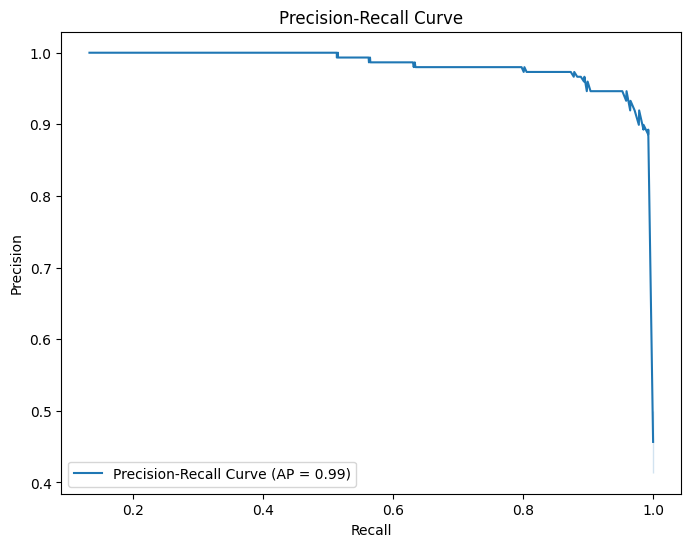

In [55]:
# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

# Plot precision-recall curve using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(x=precision, y=recall, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [56]:
y_true_pred = pd.DataFrame({'y_true': y_true, 'y_pred': [x[0] for x in y_pred]})

In [57]:
y_true_pred

,y_true,y_pred
0,0.0,0.000021
1,0.0,0.000146
2,0.0,0.000018
3,1.0,0.999184
4,1.0,0.999231
...,...,...
1110,1.0,0.999254
1111,0.0,0.000025
1112,0.0,0.000049
1113,0.0,0.000021


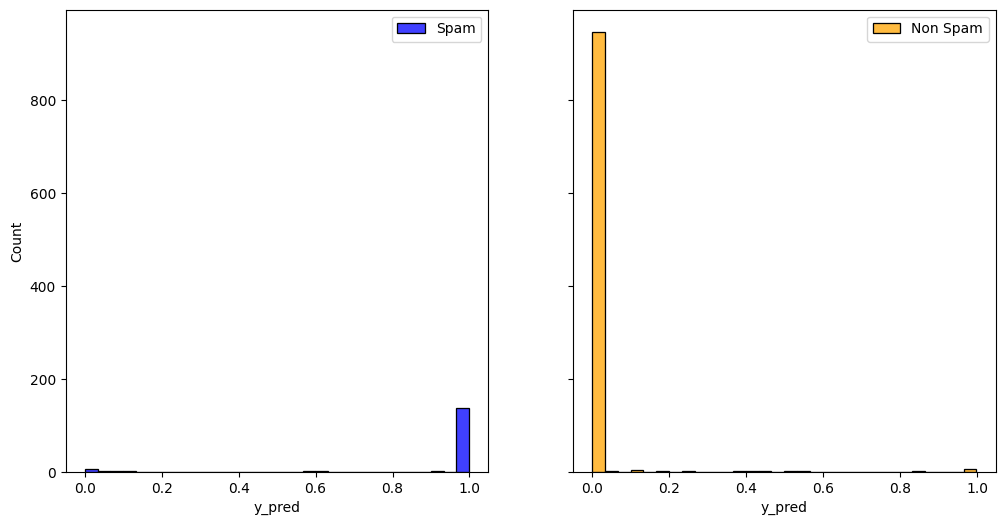

In [58]:
# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the histograms side by side using Seaborn
sns.histplot(y_true_pred[y_true_pred['y_true'] == 1]['y_pred'], bins=30, ax=axes[0], color='blue', label='Spam')
sns.histplot(y_true_pred[y_true_pred['y_true'] == 0]['y_pred'], bins=30, ax=axes[1], color='orange', label='Non Spam')

# Add legend
axes[0].legend()
axes[1].legend()

# Show the plot
plt.show()

In [59]:
len(y_true_pred[y_true_pred['y_pred'] > 0.5])/len(y_true_pred)

0.1336322869955157